<a href="https://colab.research.google.com/github/bullyhunter1917/Studies/blob/main/ML/Assignment4_Micha%C5%82_Mr%C3%B3z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 4


## Important notes

**Submission deadline:**
**lab session of the week 7.11-11.11 2022**

**Points: 1+2+2+1=4**

Please let us know about any problems with it -- we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

## MNIST

In [ ]:
# Standard IPython notebook imports
%matplotlib inline

import os

import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import scipy.stats as sstats

import seaborn as sns
from sklearn import datasets

# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat

sns.set_style('whitegrid')

In [ ]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

In [ ]:
with np.load('mnist.npz') as data:
    mnist_full_train_data_uint8 = data['train_data']
    mnist_full_train_labels_int64 = data['train_labels']
    mnist_test_data_uint8 = data['test_data']
    mnist_test_labels_int64 = data['test_labels']
        
# Split train data into train and validation sets
X_trn = mnist_full_train_data_uint8[:50000]
y_trn = mnist_full_train_labels_int64[:50000]
X_tst = mnist_full_train_data_uint8[50000:]
y_tst = mnist_full_train_labels_int64[50000:]

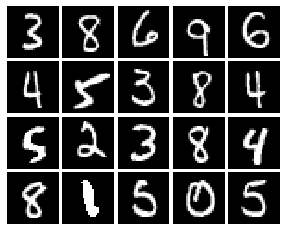

In [ ]:
plot_mat(X_tst[:20, None], cmap='gray')

In [ ]:
X_trn = X_trn.reshape(-1,28*28)
X_tst = X_tst.reshape(-1,28*28)

## kNN cosine similarity 

In previous problems you've discovered how to compute nearest neighbors using Euclidian distance. However, Euclidian distance is not the only one that you can use to measure proximity of points.

In Machine Learning very often we calculate similarity between vectors using the dot product or the correlation coefficient between them, which we can also call the cosine similarity. You will see this in Deep Learning class in Convolutional Neural Networks for Image Recognition tasks, and in Transformers for Natural Language Processing.

Let $x\in \mathbb{R}^N$ and $y\in \mathbb{R}^N$ be two vectors. Their cosine similarity is defined as:

\begin{equation}
    s_\text{cos}(x,y) = \frac{x \cdot y}{\|x\| \|y\|} = \cos\left(\theta(x,y)\right),
\end{equation}
where $\theta(x,y)$ is the unsigned angle between $x$ and $y$.



To get an idea why it can work let us plot the correlation matrix for an ordered (according to the 0,1,...,9 labels) subset of the MNIST data.

In [ ]:
X_subset = X_trn[:2000]
y_subset = y_trn[:2000]

In [ ]:
X_ordered = X_subset[np.argsort(y_subset)]
y_ordered = y_subset[np.argsort(y_subset)]

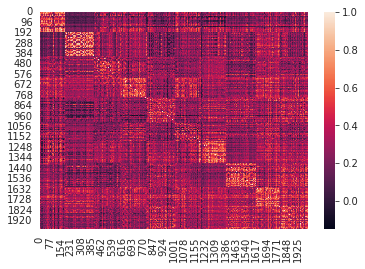

In [ ]:
import seaborn as sns

sns.heatmap(np.corrcoef(X_ordered))

You can see that squares at the diagonal are brighter. It's because these squares correspond to the vectors with the same labels.

### Normalization [1p]

For the cosine similarity to work, we need data that will be normalized. Meaning, that we want every row (and row corresponds to an image) to have zero mean and standard deviation equal to `1`.
Roughly it should mean that instead of operating on the initial $x$ representing an image we prefer to operate on $$ (x - \mbox{mean}(x))/\mbox{std}(x).$$

Task: take `X_trn` and normalize it, let the output be in `X_norm_trn`.

In [ ]:
from sklearn.preprocessing import normalize
#TODO

print(X_trn)

X_norm_trn = np.array([(x - x.mean())/x.std() for x in X_trn])
X_norm_tst = np.array([(x - x.mean())/x.std() for x in X_tst])



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
np.mean(X_norm_trn, axis=1).round(12)

array([ 0.,  0.,  0., ..., -0., -0., -0.])

In [ ]:
np.std(X_norm_trn, axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

If everything went ok, then you should get a correlation matrix of `X_trn`, simply by multiplying `X_norm_trn` by itself (but transposed ofc). Also, we need to divide it by 784; you know why?

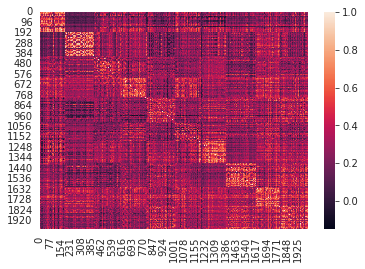

In [ ]:
sns.heatmap(X_norm_trn[np.argsort(y_subset)] @ X_norm_trn[np.argsort(y_subset)].T/784)

### Implement kNN with cosine similarity [2p]

Implement k-nearest neighbor algorithm, but this time using cosine similarity. 
This time implement it fully on your own. On top of that make it look like a model satisfying the standard sklearn API:

In [ ]:
class kNearestNeighborsCosine:
    k_var = 0
    X_trn_local = []
    y_trn_local = []


    def __init__(self, k):
        self.k_var = k
    # liczenie długości i zwracanie topowych
    def fit(self, X_trn, y_trn):
        self.X_trn_local = X_trn
        self.y_trn_local = y_trn
    # na podstawie k brać k najlepszych i określić kto wygrywa
    def predict(self, X_tst):
        
        dist = np.dot(self.X_trn_local, X_tst.T)/(np.sqrt(np.sum(self.X_trn_local**2, axis=1)[:, np.newaxis]) * np.sqrt(np.sum(X_tst**2, axis=1)))
        closest = np.argsort(-dist, axis=0)
        targets = y_trn[closest]
        return sstats.mode(targets[:self.k_var:]).mode

In [ ]:
cos = kNearestNeighborsCosine(5)
print(cos.k_var)
cos.fit(X_norm_trn, y_trn)
print(cos.predict(X_norm_tst[:20]))
print(y_tst[:20])

# A = np.array([[1, 2, 3],
#               [2, 3, 4],
#               [5, 6, 7]])
# B = np.array([[1, 2, 3],
#               [2, 3, 4]])

# print(np.dot(A, B.T))
# print(np.sum(A**2, axis=1)[:, np.newaxis])
# print(np.sum(B**2, axis=1))
# print(np.sum(A**2, axis=1)[:, np.newaxis] * np.sum(B**2, axis=1))
# print(np.dot(A, B.T) / (np.sum(A**2, axis=1)[:, np.newaxis] * np.sum(B**2, axis=1)))
# C = np.array([[4,9],
#               [25,49]])
              

5
[[3 8 6 9 6 4 5 3 8 4 5 2 3 8 4 8 1 5 0 5]]
[3 8 6 9 6 4 5 3 8 4 5 2 3 8 4 8 1 5 0 5]


Of course, during hyperparameter tuning of parameter `k` you may not want to calculate the correlation matrix all over again. Feel free to change the above API into:

In [ ]:
#Because of too big data I had to make this class contain list of k insted of single k and don't memorize distance matrix

class kNearestNeighborsCosine:
    k_vars = []
    X_trn_local = []
    y_trn_local = []

    def __init__(self, k):
        self.k_vars = k
    def fit(self, X_trn, y_trn, dists=None):
        self.X_trn_local = X_trn
        self.y_trn_local = y_trn      
    
    def predict(self, X_tst):
        dist = np.dot(self.X_trn_local, X_tst.T)/(np.sqrt(np.sum(self.X_trn_local**2, axis=1)[:, np.newaxis]) * np.sqrt(np.sum(X_tst**2, axis=1)))
        closest = np.argsort(-dist, axis=0)
        targets = y_trn[closest]

        preds = {}
        for k in self.k_vars:
            preds[k] = sstats.mode(targets[:k:]).mode

        return preds

where `dists` is the matrix containing the cosine similarity. In the sklearn implementation similar behavior is obtained via parameter `metric="precomputed"`, see https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html 

### Implement kNN with leave-one-out [2p]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

class kNearestNeighborsCosine_loo:
    k_vars = []
    X_trn_local = []
    y_trn_local = []

    def __init__(self, k):
        self.k_vars = k
    def fit(self, X_trn, y_trn, dists=None):
        self.X_trn_local = X_trn
        self.y_trn_local = y_trn       
    
    def predict(self, X_tst):
        dist = cosine_similarity(self.X_trn_local, X_tst)
        #dist = np.dot(self.X_trn_local, X_tst.T)/(np.sqrt(np.sum(self.X_trn_local**2, axis=1)[:, np.newaxis] * np.sum(X_tst**2, axis=1)))
        closest = np.argsort(-dist, axis=0)
        targets = y_trn[closest]

        preds = {}
        for k in self.k_vars:
            preds[k] = sstats.mode(targets[1:k+1:]).mode
      
        return preds

In [ ]:
def err_rates(preds, test_Y):
    ret = {}
    for k, preds_k in  preds.items():
        ret[k] = np.sum(preds_k!=test_Y)/test_Y.shape[0]
    return ret

In [ ]:
def batched_KNN(train_X, train_Y, test_X, ks, klasa, verbose=False, batch_size=200):
    cos = klasa(ks)
    cos.fit(train_X, train_Y)
    all_preds = {k: [] for k in ks}
    for i in tqdm(range(0, test_X.shape[0], batch_size)):
        batch_X = test_X[i:i + batch_size]
        
        preds = cos.predict(batch_X)

        for k in all_preds.keys():
            all_preds[k] = np.concatenate((all_preds[k], preds[k][0]))
    return all_preds

  0%|          | 0/250 [00:00<?, ?it/s]

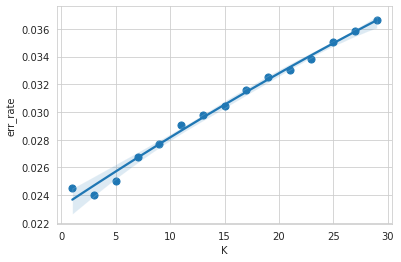

In [ ]:
mnist_loo = batched_KNN(X_norm_trn, y_trn, X_norm_trn, [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29], kNearestNeighborsCosine_loo)

errs = err_rates(mnist_loo, y_trn)

results = []

for k, errs_k in errs.items():
    results.append({'K':k, 'err_rate': errs_k})

results_df = pd.DataFrame(results)

plt.figure()
sns.regplot(x='K', y=results_df.err_rate, data=results_df, x_estimator=np.mean, order=2)

Here we can see the best k is 3 or 1.

Perform the same leave-one-out error validation, and `k` tuning as in Lab Assignment 3.

### Implement batched kNN for MNIST [1p]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


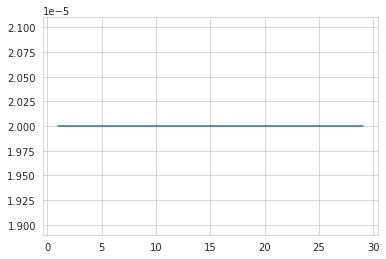

In [ ]:
# In previous task I defined batched kNN so here i only use function to calculate knn for test set 

mnist = batched_KNN(X_norm_trn, y_trn, X_norm_tst, [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29], kNearestNeighborsCosine)

errs = err_rates(mnist_loo, y_trn)

plt.plot([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29], [errs[k] for k in [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]])

Implement the same batched approach to classify all the images from the test set.